In [441]:
import io
import re
import pandas as pd
import matplotlib.pyplot as plt
import chess
import chess.pgn
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
import seaborn as sns



# get data

In [293]:
ogdf = pd.read_csv('club_games_data.csv')

In [294]:
df = ogdf.copy()

# Making data

In [295]:
def count_pawn_moves(pgn_str):
    pgn = chess.pgn.read_game(io.StringIO(pgn_str))
    board = pgn.board()
    pawn_moves = {'White': [0]*8, 'Black': [0]*8}
    for move in pgn.mainline_moves():
        board.push(move)
        rank = chess.square_rank(move.to_square)
        moved_piece = board.piece_at(move.to_square)
        if not moved_piece:
            return{'White': 0, 'Black': 0} 
        if moved_piece.piece_type == chess.PAWN:
            if moved_piece.color == chess.WHITE:
                pawn_moves['White'][rank] += 1
            else:
                pawn_moves['Black'][rank] += 1
    return pawn_moves

In [296]:
df[['black_pawn_moves', 'white_pawn_moves']] = ogdf.apply(lambda row: pd.Series(count_pawn_moves(row['pgn'])), axis=1)

In [297]:
df['white_win'] = df.apply(lambda row: 1 if row['white_result'] == 'win' else 0, axis=1)
df['black_win'] = df.apply(lambda row: 1 if row['black_result'] == 'win' else 0, axis=1)


In [416]:
df['white_simple_result']=df.apply(lambda row: 1 if row['white_result'] == 'win' else 0 if row['black_result']=='win' else 0.5, axis=1)
df['black_simple_result']=df.apply(lambda row: 1 if row['black_result'] == 'win' else 0 if row['white_result']=='win' else 0.5, axis=1)

In [309]:
df['Elo_class'] = pd.cut(df['white_rating'], bins=[0, 500, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2300, 2400, 2500, 2700, 3100], labels=[
                         '<500', '500-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200', '2200-2300', '2300-2400', '2400-2500', '2500-2700', '2700-3000'])

df['sum_white_pawn_moves'] = df['white_pawn_moves'].apply(lambda x: sum(x))

df['sum_black_pawn_moves'] = df['black_pawn_moves'].apply(lambda x: sum(x))

df['sum_pawn_moves'] = df['sum_white_pawn_moves'] + df['sum_black_pawn_moves']



In [417]:
df.head()

,white_username,black_username,white_id,black_id,white_rating,black_rating,white_result,black_result,time_class,time_control,...,black_pawn_moves,white_pawn_moves,white_win,black_win,white_simple_result,black_simple_result,Elo_class,sum_white_pawn_moves,sum_black_pawn_moves,sum_pawn_moves
0,-Amos-,miniman2804,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/miniman2804,1708,1608,win,checkmated,daily,1/259200,...,"[0, 0, 1, 4, 2, 0, 0, 0]","[0, 0, 0, 0, 4, 3, 0, 0]",1,0,1.0,0.0,1600-1800,7,7,14
1,-Amos-,koltcho69,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/koltcho69,1726,1577,win,resigned,daily,1/172800,...,"[0, 0, 1, 4, 2, 1, 1, 0]","[0, 0, 0, 1, 4, 5, 0, 0]",1,0,1.0,0.0,1600-1800,10,9,19
2,-Amos-,enhmandah,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/enhmandah,1727,842,win,resigned,daily,1/172800,...,"[0, 0, 1, 3, 0, 0, 0, 0]","[0, 0, 0, 2, 3, 1, 0, 0]",1,0,1.0,0.0,1600-1800,6,4,10
3,enhmandah,-Amos-,https://api.chess.com/pub/player/enhmandah,https://api.chess.com/pub/player/-amos-,819,1727,checkmated,win,daily,1/172800,...,"[0, 0, 2, 2, 0, 0, 0, 0]","[0, 0, 0, 0, 2, 1, 0, 0]",0,1,0.0,1.0,500-1000,3,4,7
4,-Amos-,Shalllow-Blue,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/shalllow-blue,1729,1116,win,resigned,daily,1/172800,...,"[0, 0, 1, 4, 3, 2, 0, 0]","[0, 0, 0, 1, 1, 5, 0, 0]",1,0,1.0,0.0,1600-1800,7,10,17


# Cleaning Data


In [300]:
df = df[df['rules'] == 'chess']  # remove non-chess games
df = df[df["pgn"].apply(lambda pgn: chess.pgn.read_game(
    io.StringIO(pgn)).mainline_moves() != None)]  # remove games with no moves


In [301]:
df = df[df["pgn"].apply(lambda pgn: "Endgame" not in chess.pgn.read_game(
    io.StringIO(pgn)).headers["Event"])]  # remove endgame puzzles


In [302]:
for index, row in df.iterrows():  # remove abandoned games
    pgn = row["pgn"]
    game = chess.pgn.read_game(io.StringIO(pgn))
    start_time = game.headers["StartTime"]
    end_time = game.headers["EndTime"]
    if start_time == end_time:
        df.drop(index, inplace=True)


In [310]:
df = df[df['sum_pawn_moves']!=0]

In [353]:
df = df[df['black_result'] != 'abandoned']
df = df[df['white_result'] != 'abandoned']

In [311]:
df.head()

,white_username,black_username,white_id,black_id,white_rating,black_rating,white_result,black_result,time_class,time_control,...,black_pawn_moves,white_pawn_moves,white_win,black_win,white_simple_result,black_simple_result,Elo_class,sum_white_pawn_moves,sum_black_pawn_moves,sum_pawn_moves
0,-Amos-,miniman2804,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/miniman2804,1708,1608,win,checkmated,daily,1/259200,...,"[0, 0, 1, 4, 2, 0, 0, 0]","[0, 0, 0, 0, 4, 3, 0, 0]",1,0,win,loss,1600-1800,7,7,14
1,-Amos-,koltcho69,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/koltcho69,1726,1577,win,resigned,daily,1/172800,...,"[0, 0, 1, 4, 2, 1, 1, 0]","[0, 0, 0, 1, 4, 5, 0, 0]",1,0,win,loss,1600-1800,10,9,19
2,-Amos-,enhmandah,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/enhmandah,1727,842,win,resigned,daily,1/172800,...,"[0, 0, 1, 3, 0, 0, 0, 0]","[0, 0, 0, 2, 3, 1, 0, 0]",1,0,win,loss,1600-1800,6,4,10
3,enhmandah,-Amos-,https://api.chess.com/pub/player/enhmandah,https://api.chess.com/pub/player/-amos-,819,1727,checkmated,win,daily,1/172800,...,"[0, 0, 2, 2, 0, 0, 0, 0]","[0, 0, 0, 0, 2, 1, 0, 0]",0,1,loss,win,500-1000,3,4,7
4,-Amos-,Shalllow-Blue,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/shalllow-blue,1729,1116,win,resigned,daily,1/172800,...,"[0, 0, 1, 4, 3, 2, 0, 0]","[0, 0, 0, 1, 1, 5, 0, 0]",1,0,win,loss,1600-1800,7,10,17


# Logistic Regression

## Binary game results

#### *white pieces*

In [399]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_wins = df['white_win'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_wins, test_size=0.2, random_state=42)

w_model = LogisticRegression()

w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)

yw_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

print('accuracy: ', accuracy_score(yw_test, w_pred))
print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

accuracy:  0.5519776268477826
ROC AUC:  0.5831364601921385


#### *black pieces*

In [400]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_wins = df['black_win'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_wins, test_size=0.2, random_state=42)

b_model = LogisticRegression()

b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
yb_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))
print('ROC AUC: ', roc_auc_score(yb_test, yb_pred_proba))

accuracy:  0.5614063124250899
ROC AUC:  0.5948158028194988


#### Coefficients by rank and colour

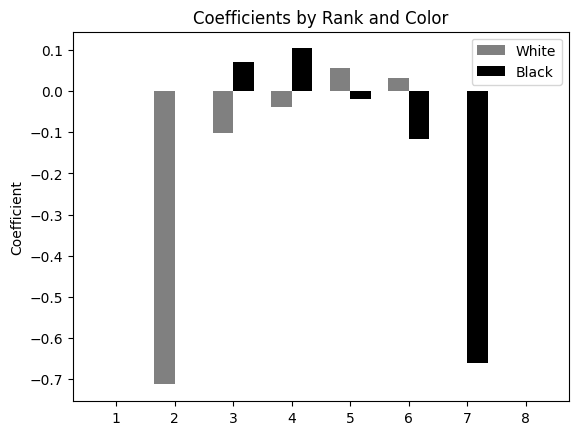

In [401]:
w_coefs = w_model.coef_.ravel()
b_coefs = b_model.coef_.ravel()

# Set the x positions of the bars
bar_width = 0.35
white_pos = np.arange(8)
black_pos = white_pos + bar_width

# Plot the bars
fig, ax = plt.subplots()
white_bars = ax.bar(white_pos, w_coefs, width=bar_width, label='White', color='grey')
black_bars = ax.bar(black_pos, b_coefs, width=bar_width, label='Black', color='black')

ax.set_ylabel('Coefficient')
ax.set_title('Coefficients by Rank and Color')
ax.set_xticks(white_pos + bar_width / 2)
ax.set_xticklabels(range(1,9))
ax.legend()

#### ROC for white

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(yw_test, yw_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for white')
plt.legend(loc="lower right")
plt.show()

#### ROC for black

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(yb_test, yb_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for black')
plt.legend(loc="lower right")
plt.show()

## 10 unique game results

#### *white pieces*

accuracy:  0.496763883339992


/home/anton/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


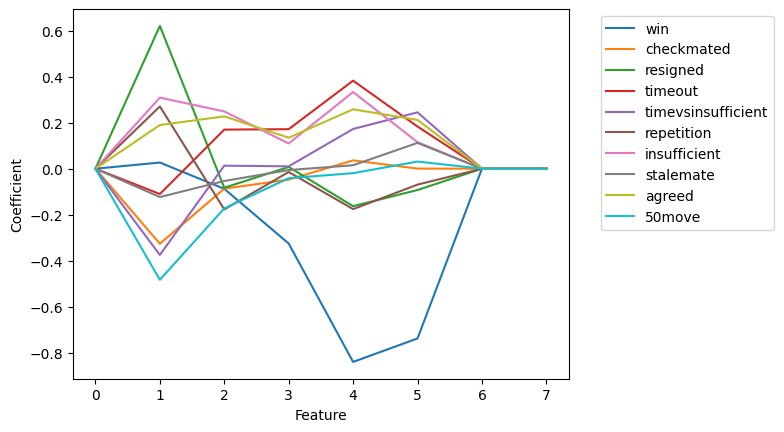

In [379]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_results, test_size=0.2, random_state=42)

w_model = LogisticRegression(multi_class='multinomial')
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
w_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

print('accuracy: ', accuracy_score(yw_test, w_pred))

coeffs = w_model.coef_
game_results = df['white_result'].unique()

fig, ax = plt.subplots()
for i in range(coeffs.shape[0]):
    ax.plot(coeffs[i], label=game_results[i])

ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient')
ax.legend(bbox_to_anchor=(1.05,1))


#### *black pieces*

accuracy:  0.4773471833799441


/home/anton/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


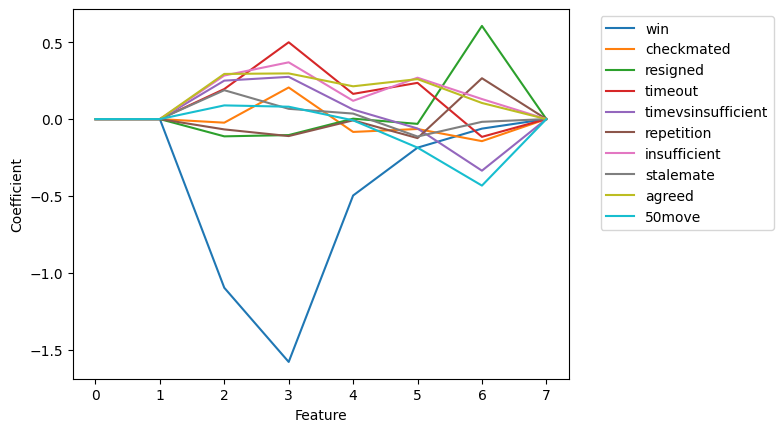

In [402]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_results = df['black_result'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_results, test_size=0.2, random_state=42)

b_model = LogisticRegression(multi_class='multinomial')
b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
b_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))

coeffs = b_model.coef_
game_results = df['white_result'].unique()

fig, ax = plt.subplots()
for i in range(coeffs.shape[0]):
    ax.plot(coeffs[i], label=game_results[i])

ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient')
ax.legend(bbox_to_anchor=(1.05,1))

## Win/Loss/Draw game results

#### white pieces

accuracy:  0.5334398721534159


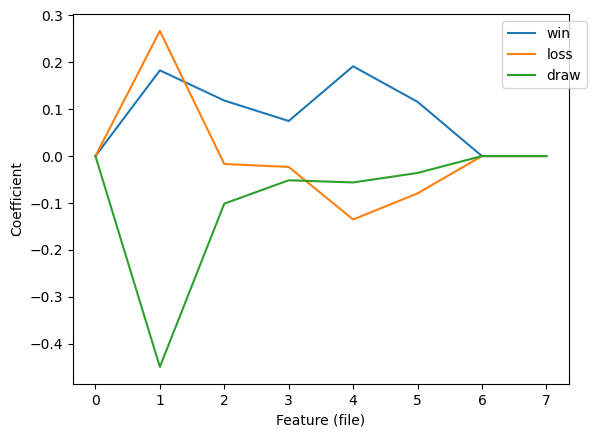

In [383]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_simple_results = df['white_simple_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_simple_results, test_size=0.2, random_state=42)

w_model = LogisticRegression(multi_class='auto')
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
w_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

coeffs = w_model.coef_
game_results = df['white_simple_result'].unique()

print('accuracy: ', accuracy_score(yw_test, w_pred))
# plot the coefficients for each class
fig, ax = plt.subplots()
for i in range(coeffs.shape[0]):
    ax.plot(coeffs[i], label=game_results[i])

ax.set_xlabel('Feature (file)')
ax.set_ylabel('Coefficient')
ax.legend(bbox_to_anchor=(1.05,1))

#### black pieces

accurracy:  0.5479824210946864


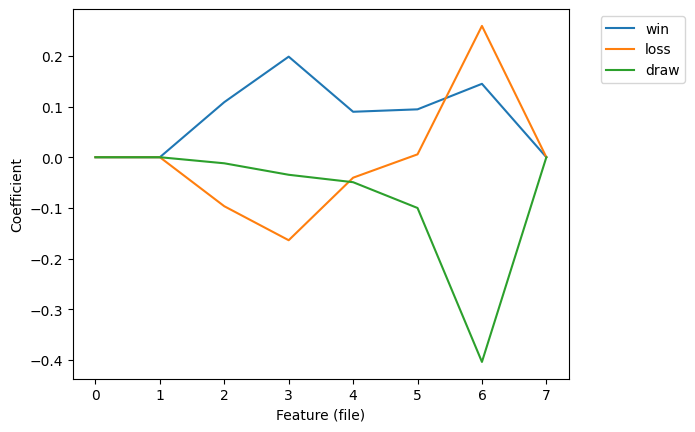

In [385]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_simple_results = df['black_simple_result'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_simple_results, test_size=0.2, random_state=42)

b_model = LogisticRegression(multi_class='auto')
b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
b_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

coeffs = b_model.coef_
game_results = df['white_simple_result'].unique()

print('accurracy: ', accuracy_score(yb_test, b_pred))
# plot the coefficients for each class
fig, ax = plt.subplots()
for i in range(coeffs.shape[0]):
    ax.plot(coeffs[i], label=game_results[i])

ax.set_xlabel('Feature (file)')
ax.set_ylabel('Coefficient')
ax.legend(bbox_to_anchor=(1.05,1))

## Binary game results

#### *white pieces*

In [421]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_wins = df['white_win'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_wins, test_size=0.2, random_state=42)

w_model = LinearRegression()

w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)

# yw_pred_proba = w_model.predict_proba(Xw_test)[:, 1]
print(yw_test)
print('accuracy: ', accuracy_score(yw_test, w_pred))
# print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 

ValueError: Classification metrics can't handle a mix of binary and continuous targets

#### *black pieces*

In [414]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_wins = df['black_win'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_wins, test_size=0.2, random_state=42)

b_model = LinearRegression()

b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
# yb_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))
# print('ROC AUC: ', roc_auc_score(yb_test, yb_pred_proba))

ValueError: Classification metrics can't handle a mix of binary and continuous targets

## win/loss/draw game results

#### white pieces

In [426]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_simple_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_results, test_size=0.2, random_state=42)

w_model = LinearRegression()

w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)

print('accuracy: ', r2_score(yw_test, w_pred))
# print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

accuracy:  0.023678877419305966


# Random Forest Classifier

## 10 game results

#### *white pieces*

0.4864562524970036


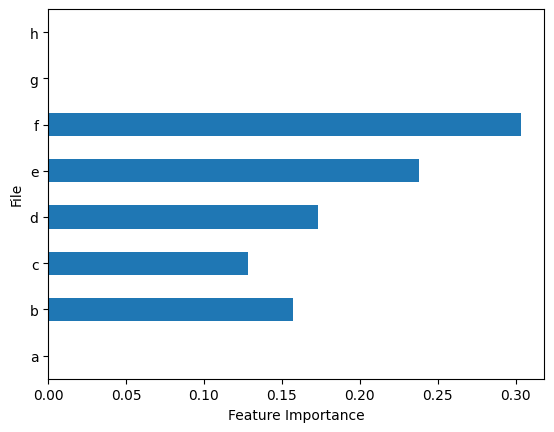

In [372]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_results, test_size=0.2, random_state=42)

w_model = RandomForestClassifier()
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
yw_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

print(accuracy_score(yw_test, w_pred))
# print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

# plot feature importances
importances = pd.Series(w_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

#### *black pieces*

accuracy:  0.4678385936875749


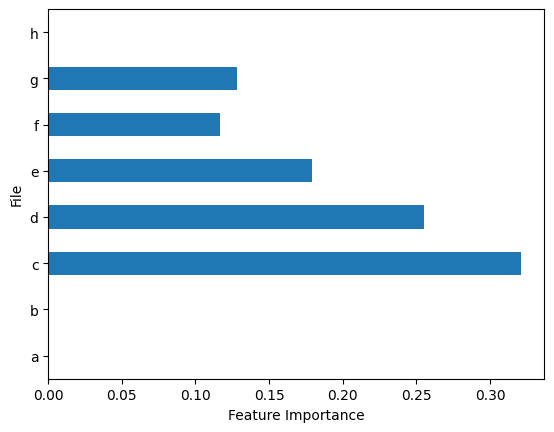

In [386]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_results = df['black_result'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_results, test_size=0.2, random_state=42)

b_model = RandomForestClassifier()

b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
yb_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))
# print('ROC AUC: ', roc_auc_score(yb_test, yb_pred_proba))

# plot feature importances
importances = pd.Series(b_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

## win/loss/draw game results

#### *white pieces*

0.5325609268877347


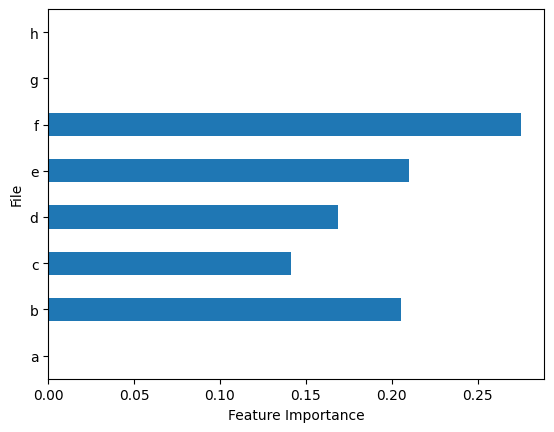

In [404]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_simple_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_results, test_size=0.2, random_state=42)

w_model = RandomForestClassifier()
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
yw_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

print(accuracy_score(yw_test, w_pred))
# print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

# plot feature importances
importances = pd.Series(w_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

#### black pieces

accuracy:  0.5350379544546544


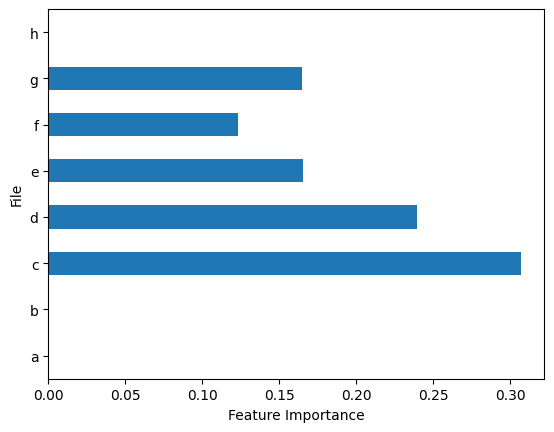

In [405]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_results = df['black_simple_result'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_results, test_size=0.2, random_state=42)

b_model = RandomForestClassifier()

b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
yb_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))
# print('ROC AUC: ', roc_auc_score(yb_test, yb_pred_proba))

# plot feature importances
importances = pd.Series(b_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

## Binary game results

#### white pieces

0.5486216540151818


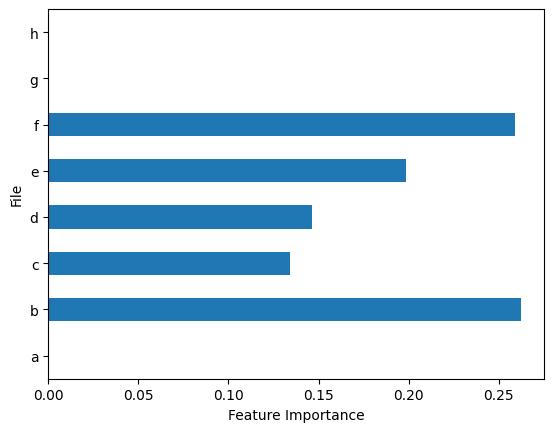

In [407]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_win'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_results, test_size=0.2, random_state=42)

w_model = RandomForestClassifier()
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
yw_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

print(accuracy_score(yw_test, w_pred))
# print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

# plot feature importances
importances = pd.Series(w_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

#### black pieces

accuracy:  0.5498202157411106


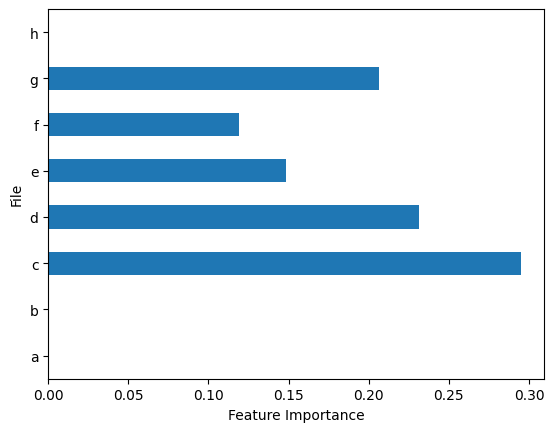

In [408]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_results = df['black_win'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_results, test_size=0.2, random_state=42)

b_model = RandomForestClassifier()

b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
yb_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))
# print('ROC AUC: ', roc_auc_score(yb_test, yb_pred_proba))

# plot feature importances
importances = pd.Series(b_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

# K Nearest Neighboours

## Binary result classification

#### *white pieces*

In [443]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_wins = df['white_win'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
    white_pawn_moves, white_wins, test_size=0.2, random_state=42)

knn_model = KNeighborsClassifier(n_neighbors=10)
knn_model.fit(Xw_train, yw_train)

w_pred = knn_model.predict(Xw_test)

# Perform 10-fold cross-validation and calculate MSE for each fold
mse_scores = cross_val_score(knn_model, Xw_train, yw_train, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores

# Calculate accuracy, bias and variance
accuracy = np.mean(1 - mse_scores)
bias = (yw_test - knn_model.predict(Xw_test)) ** 2
bias = np.mean(bias)
variance = np.var(knn_model.predict(Xw_train), ddof=1)

print("Accuracy:", accuracy)
print("Bias:", bias)
print("Variance:", variance)

Accuracy: 0.523113287032584
Bias: 0.4755093887335198
Variance: 0.23539278131955102


#### finding k for white

#### info on knn metrics

First, we split the dataset into training and testing sets. Then, we use k-fold cross-validation on the training set to obtain a more accurate estimate of the model's performance.

During k-fold cross-validation, the training set is divided into k subsets or "folds". For each fold, the model is trained on the remaining k-1 folds and evaluated on the held-out fold. This process is repeated k times, with each fold serving as the test set once.

The accuracy of the model is the average of the accuracy scores obtained on each fold during cross-validation. This metric measures the percentage of correct predictions made by the model.

The bias of the model is the difference between the expected prediction and the true value. High bias means that the model is underfitting the data, i.e. it is not complex enough to capture the underlying patterns in the data. This can lead to poor performance on both the training and test sets.

The variance of the model is the amount by which the predictions vary for different subsets of the training data. High variance means that the model is overfitting the data, i.e. it is too complex and is fitting the noise in the data instead of the underlying patterns. This can lead to good performance on the training set but poor performance on the test set.


 # Misc .

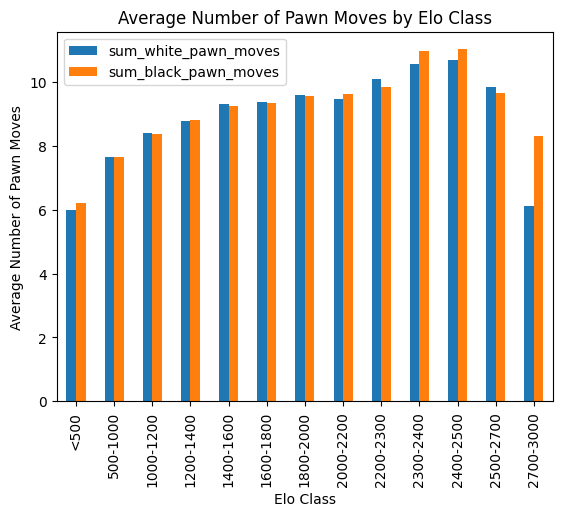

In [330]:
# Calculate average number of pawn moves for each Elo class
pawn_moves_by_elo = df.groupby(
    'Elo_class')[['sum_white_pawn_moves', 'sum_black_pawn_moves']].mean()

# Plot bar graph
pawn_moves_by_elo.plot(kind='bar')
plt.xlabel('Elo Class')
plt.ylabel('Average Number of Pawn Moves')
plt.title('Average Number of Pawn Moves by Elo Class')
plt.show()
